<a href="https://colab.research.google.com/github/jaisidhsingh/ComputerVisionPython/blob/main/mask_rcnn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [3]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [17]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask


def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

  

In [24]:
train_len = info.splits['train'].num_examples
batch_size = 64
buffer_size = 1000
steps_per_epoch = train_len // batch_size


In [25]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_data = train.cache().shuffle(buffer_size).batch(batch_size).repeat()
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test.batch(batch_size)



In [29]:
for iamge, mask in train_data.take(1):
  print(iamge.shape)
  print(mask.shape)

(64, 128, 128, 3)
(64, 128, 128, 1)


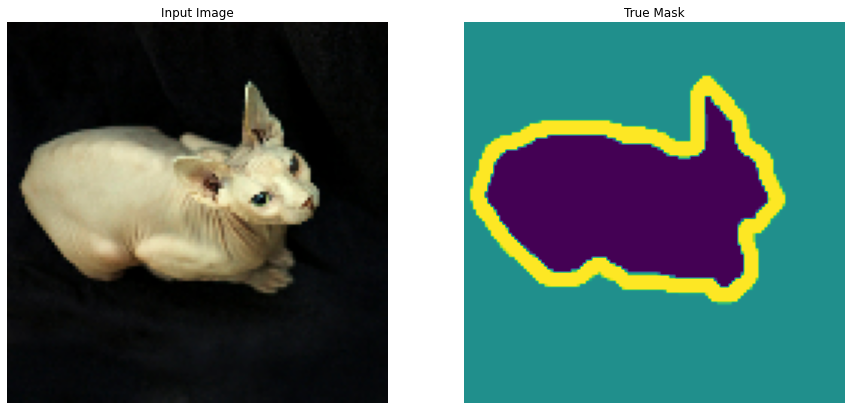

(128, 128, 3)
(128, 128, 1)


In [35]:
def display(disp_param):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(disp_param)):
    plt.subplot(1, len(disp_param), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(disp_param[i]))
    plt.axis('off')
  plt.show()




for image, mask in train.take(1):
  i, m = image, mask
display([i, m])
print(i.shape)
print(m.shape)

In [37]:
output_channels = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_ref = [
             'block_1_expand_relu', #64x64
             'block_3_expand_relu', #32x32
             'block_6_expand_relu', #16x16
             'block_13_expand_relu', #8x8
             'block_16_project', #4x4
]

layers = [base_model.get_layer(item).output for item in layer_ref]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [41]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [42]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  hops = down_stack(x)
  x = hops[-1]
  hops = reversed(hops[:-1])

  for up, hop in zip(up_stack, hops):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, hop])

  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [43]:
model = unet_model(output_channels)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

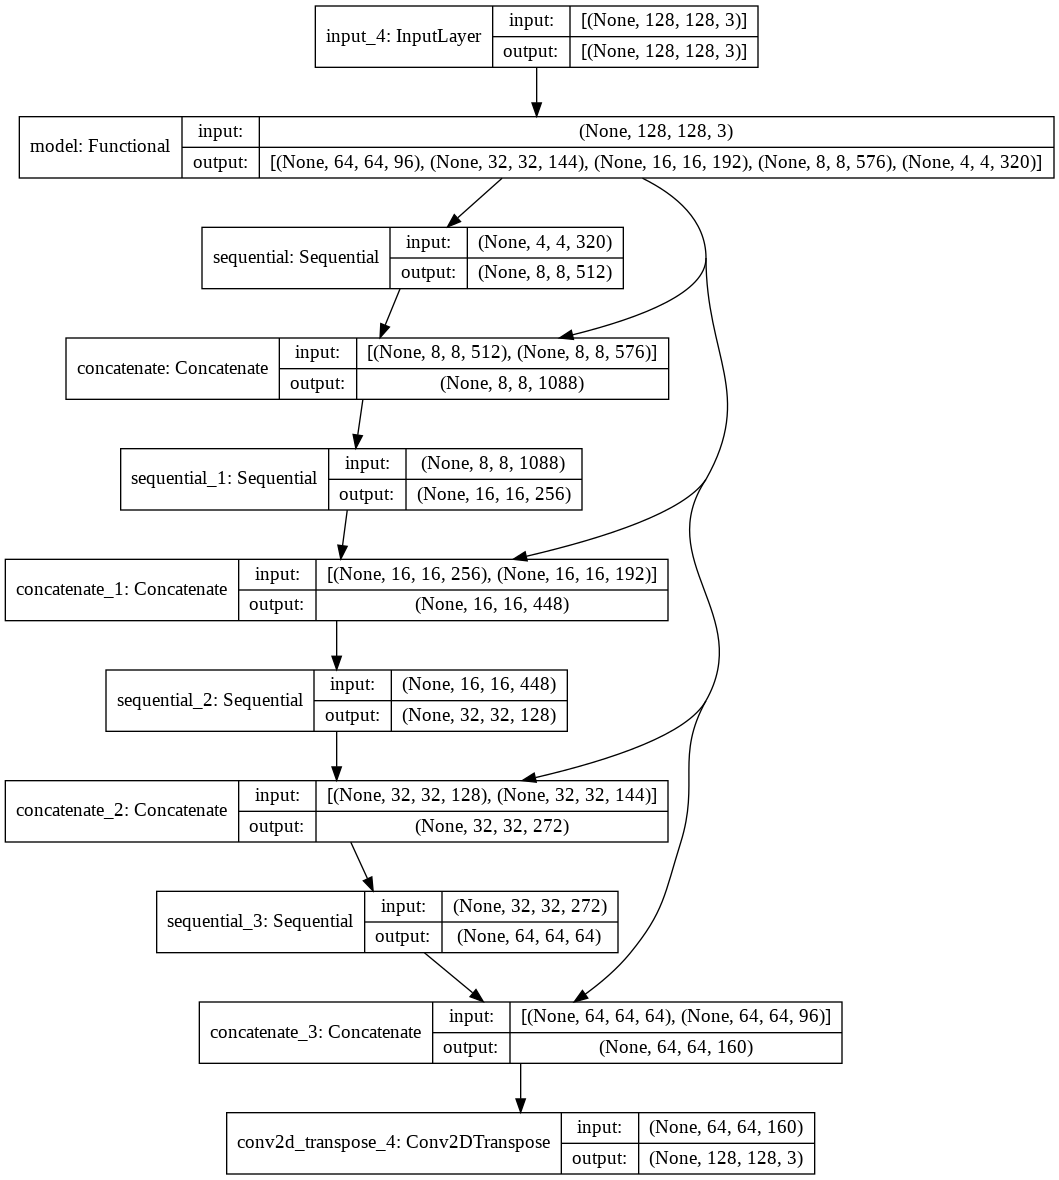

In [44]:
tf.keras.utils.plot_model(model, show_shapes=True)